## This notebook compares concordance of centrolign SVs and horhap derived SVs using windows  

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn

In [2]:
# Read in list of pairwise distances per chromosome

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df.head()

,sample1,sample2,direct_pairwise_dist,chr
0,HG03098.1,HG03784.1,0.942968,chr6
1,HG03098.1,NA20752.2,0.974936,chr6
2,HG01978.2,NA19835.1,0.999883,chr6
3,HG00741.1,NA18522.1,0.999869,chr6
4,HG00408.1,HG01496.1,0.606856,chr6


In [3]:
## This function reads in the concordance bed files 

def read_beds(folder_path, suffix):
    """
    Reads all BED files ending with 'triangles.100bp.bed' in the given folder
    and combines them into a single DataFrame with a calculated 'ratio' column.
    
    Parameters:
        folder_path (str): Path to the folder containing BED files.
        
    Returns:
        pd.DataFrame: Combined DataFrame with columns:
                      ['sample', 'window_start', 'window_end', 'centrolign_counts', 'horhap_counts', 'ratio']
    """
    
    all_dfs = []
    
    # Loop through files in folder
    for filename in os.listdir(folder_path):
        if filename.endswith(suffix):
            file_path = os.path.join(folder_path, filename)
            
            # Read the BED file
            df = pd.read_csv(
                file_path,
                sep="\t",            # assuming tab-delimited
                header=None,
                names=["sample", "window_start", "window_end", "centrolign_counts", "horhap_counts"]
            )
            # Determine the "other" sample in the file
            unique_samples = df["sample"].unique()
            if len(unique_samples) == 1:
                # Only one sample, set sample2 to None
                df["sample2"] = None
            else:
                # Create a mapping from sample to the other sample
                sample_map = {s: [o for o in unique_samples if o != s][0] for s in unique_samples}
                df["sample2"] = df["sample"].map(sample_map)
            
            # Compute ratio safely
            df["ratio"] = df.apply(
                lambda row: row["centrolign_counts"] / row["horhap_counts"]
                if row["centrolign_counts"] != 0 and row["horhap_counts"] != 0
                else 0,
                axis=1
            )
            
            all_dfs.append(df)
    
    # Concatenate all DataFrames
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        return combined_df
    else:
        # Return empty DataFrame with correct columns if no files found
        return pd.DataFrame(columns=["sample","sample2", "window_start", "window_end", 
                                     "centrolign_counts", "horhap_counts", "ratio"])


### 100bp windows, just triangles. Plotting each window separately

In [4]:
folder = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/chr12/cenhap4"
suffix = "triangles.100bp.bed"
triangles_100bp_df = read_beds(folder,suffix)
triangles_100bp_df["chr"]="chr12"
print(triangles_100bp_df.head())

      sample  window_start  window_end  centrolign_counts  horhap_counts  \
0  HG00290.1      34653281    34657558               4077              0   
1  HG00290.1      34680631    34681867                  0           1036   
2  HG00290.1      34727166    34749346              14598          15621   
3  HG00290.1      34750258    34784073              21054          24337   
4  HG00290.1      34795428    34807027               7813           7492   

     sample2     ratio    chr  
0  HG01358.1  0.000000  chr12  
1  HG01358.1  0.000000  chr12  
2  HG01358.1  0.934511  chr12  
3  HG01358.1  0.865103  chr12  
4  HG01358.1  1.042846  chr12  


In [5]:
## merge with all pairs distances 
triangles_100bp_df = triangles_100bp_df.rename(columns={"sample": "sample1"})

triangles_100bp_df_merged = (
    triangles_100bp_df
    .merge(all_pairs_dist_df, on=["sample1", "sample2","chr"], how="left")
)

triangles_100bp_df_merged.head()

,sample1,window_start,window_end,centrolign_counts,horhap_counts,sample2,ratio,chr,direct_pairwise_dist
0,HG00290.1,34653281,34657558,4077,0,HG01358.1,0.000000,chr12,0.513215
1,HG00290.1,34680631,34681867,0,1036,HG01358.1,0.000000,chr12,0.513215
2,HG00290.1,34727166,34749346,14598,15621,HG01358.1,0.934511,chr12,0.513215
3,HG00290.1,34750258,34784073,21054,24337,HG01358.1,0.865103,chr12,0.513215
4,HG00290.1,34795428,34807027,7813,7492,HG01358.1,1.042846,chr12,0.513215


In [6]:
denom = triangles_100bp_df_merged["centrolign_counts"] + triangles_100bp_df_merged["horhap_counts"]

triangles_100bp_df_merged["cen_prop"] = np.where(
    denom > 0,
    triangles_100bp_df_merged["centrolign_counts"] / denom,
    0
)
triangles_100bp_df_merged.head()

,sample1,window_start,window_end,centrolign_counts,horhap_counts,sample2,ratio,chr,direct_pairwise_dist,cen_prop
0,HG00290.1,34653281,34657558,4077,0,HG01358.1,0.000000,chr12,0.513215,1.000000
1,HG00290.1,34680631,34681867,0,1036,HG01358.1,0.000000,chr12,0.513215,0.000000
2,HG00290.1,34727166,34749346,14598,15621,HG01358.1,0.934511,chr12,0.513215,0.483074
3,HG00290.1,34750258,34784073,21054,24337,HG01358.1,0.865103,chr12,0.513215,0.463836
4,HG00290.1,34795428,34807027,7813,7492,HG01358.1,1.042846,chr12,0.513215,0.510487


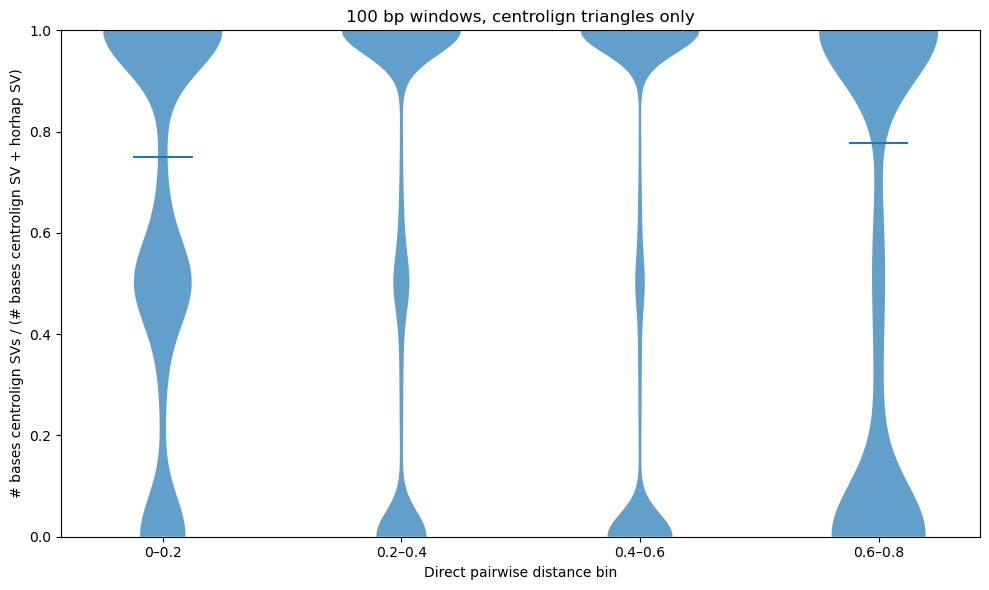

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Only the first 4 bins
bins = [0.0, 0.2, 0.4, 0.6, 0.8]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8"]

df = triangles_100bp_df_merged.copy()

df["dist_bin"] = pd.cut(
    df["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

df_plot = df.dropna(subset=["dist_bin", "cen_prop"])

data_per_bin = [
    df_plot.loc[df_plot["dist_bin"] == label, "cen_prop"].values
    for label in labels
]
plt.figure(figsize=(10, 6))

vp = plt.violinplot(
    data_per_bin,
    positions=np.arange(len(labels)),
    showmeans=False,
    showmedians=True,
    showextrema=False
)

# Style violins
for body in vp["bodies"]:
    body.set_alpha(0.7)

plt.xticks(np.arange(len(labels)), labels)
plt.xlabel("Direct pairwise distance bin")
plt.ylabel("# bases centrolign SVs / (# bases centrolign SV + horhap SV)")
plt.title("100 bp windows, centrolign triangles only")

plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [7]:
### Calculate the average concordance per sample 

# create an order-independent pair column
triangles_100bp_df_merged["sample_pair"] = triangles_100bp_df_merged.apply(
    lambda r: tuple(sorted([r["sample1"], r["sample2"]])),
    axis=1
)

# group by the unordered pair and calculate mean cen_prop
avg_cen_prop_triangles_100bp = (
    triangles_100bp_df_merged.groupby("sample_pair", as_index=False)
      .agg(
          avg_cen_prop=("cen_prop", "mean"),
          direct_pairwise_dist=("direct_pairwise_dist", "first")
      )
)
print(avg_cen_prop_triangles_100bp)


                 sample_pair  avg_cen_prop  direct_pairwise_dist
0     (HG00099.1, HG00126.2)      0.463442              0.534728
1     (HG00099.1, HG00128.1)      0.652857              0.118052
2     (HG00099.1, HG00133.1)      0.550066              0.042255
3     (HG00099.1, HG00140.2)      0.650023              0.121332
4     (HG00099.1, HG00232.2)      0.645767              0.407784
...                      ...           ...                   ...
1480  (NA20905.1, NA21106.1)      0.697483              0.415930
1481  (NA20905.1, NA21106.2)      0.629851              0.373868
1482  (NA21102.2, NA21106.1)      0.701315              0.424940
1483  (NA21102.2, NA21106.2)      0.680566              0.136764
1484  (NA21106.1, NA21106.2)      0.705731              0.396133

[1485 rows x 3 columns]


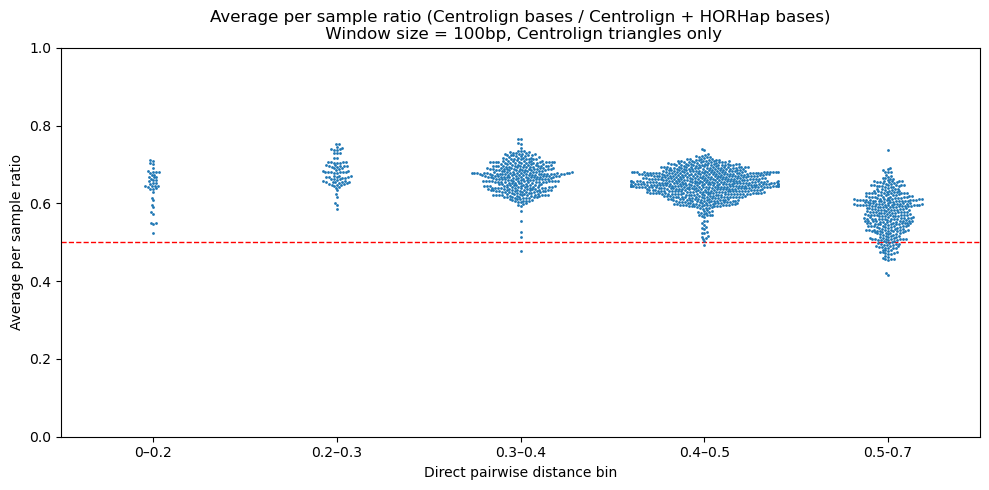

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bins = [0.0, 0.2, 0.3, 0.4, 0.5, 0.7]
labels = ["0–0.2", "0.2–0.3", "0.3–0.4", "0.4–0.5", "0.5-0.7"]

avg_cen_prop_triangles_100bp["dist_bin"] = pd.cut(
    avg_cen_prop_triangles_100bp["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

plt.figure(figsize=(10, 5))
sns.swarmplot(
    data=avg_cen_prop_triangles_100bp,
    x="dist_bin",
    y="avg_cen_prop",
    size=2
)

# horizontal reference line at y = 0.5
plt.axhline(
    y=0.5,
    color="red",
    linestyle="--",
    linewidth=1
)
plt.xlabel("Direct pairwise distance bin")
plt.ylim(0,1)
plt.ylabel("Average per sample ratio")
plt.title("Average per sample ratio (Centrolign bases / Centrolign + HORHap bases)\n Window size = 100bp, Centrolign triangles only")
plt.tight_layout()
plt.show()


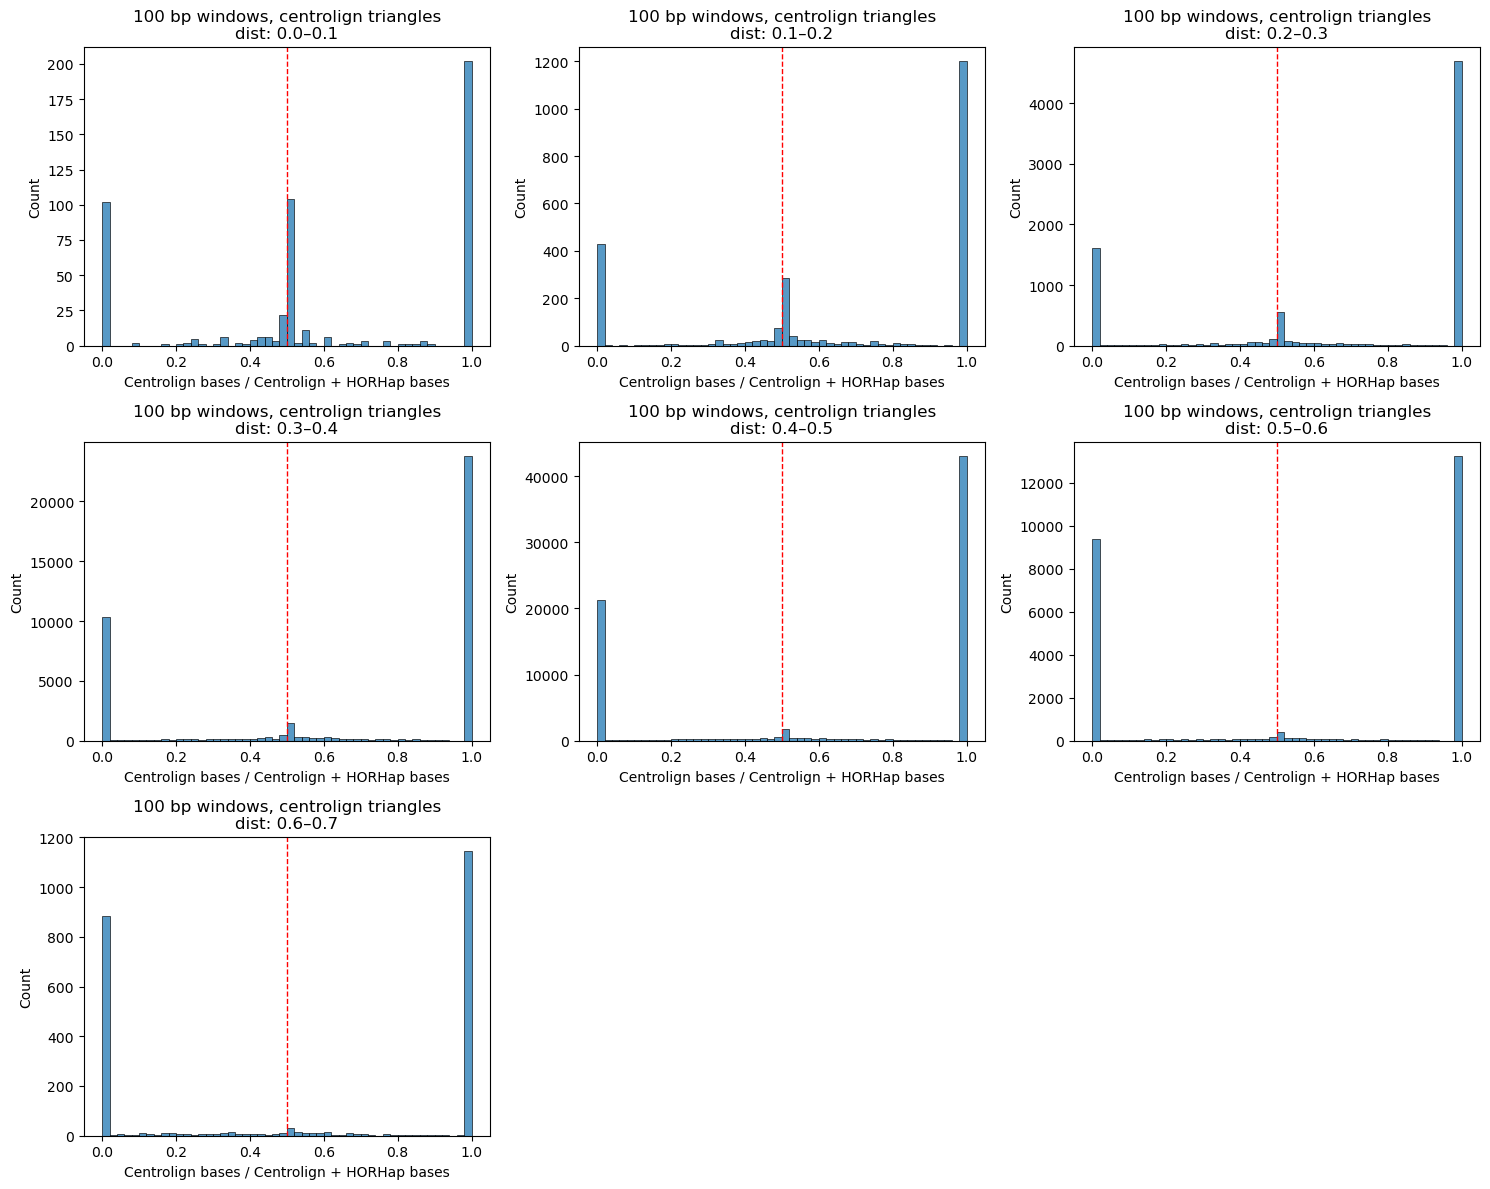

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define bins
bins = [
    (0.0, 0.1),
    (0.1, 0.2),
    (0.2, 0.3),
    (0.3, 0.4),
    (0.4, 0.5),
    (0.5, 0.6),
    (0.6, 0.7),
]

# Create subplots (adjust layout as needed)
fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(15, 12)
)

axes = axes.flatten()

for ax, (low, high) in zip(axes, bins):
    df_bin = triangles_100bp_df_merged[
        (triangles_100bp_df_merged["direct_pairwise_dist"] >= low) &
        (triangles_100bp_df_merged["direct_pairwise_dist"] < high)
    ]

    sns.histplot(
        data=df_bin,
        x="cen_prop",
        bins=50,
        ax=ax
    )

    ax.axvline(
        0.5,
        color="red",
        linestyle="--",
        linewidth=1
    )

    ax.set_title(f"100 bp windows, centrolign triangles\ndist: {low:.1f}–{high:.1f}")
    ax.set_xlabel("Centrolign bases / Centrolign + HORHap bases")
    ax.set_ylabel("Count")

# Remove unused panels (since 3x3 = 9 but we only need 7)
for ax in axes[len(bins):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


### 100 bp windows, all SVs. Plotting concordance for each window separately 

In [35]:
folder = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/chr12/cenhap4"
suffix = "all_SVs.100bp.bed"
all_svs_100bp_df = read_beds(folder,suffix)
all_svs_100bp_df["chr"]="chr12"
print(all_svs_100bp_df.head())

      sample  window_start  window_end  centrolign_counts  horhap_counts  \
0  HG01109.1      34766195    34767754               1359              0   
1  HG01109.1      34867956    34869193                  0           1037   
2  HG01109.1      34872067    34875664               3397              0   
3  HG01109.1      34897963    34905639               7476              0   
4  HG01109.1      34913485    34917082               3397              0   

     sample2  ratio    chr  
0  HG01940.2    0.0  chr12  
1  HG01940.2    0.0  chr12  
2  HG01940.2    0.0  chr12  
3  HG01940.2    0.0  chr12  
4  HG01940.2    0.0  chr12  


In [36]:
## merge with all pairs distances 

all_svs_100bp_df = all_svs_100bp_df.rename(columns={"sample": "sample1"})

all_svs_100bp_df_merged = (
    all_svs_100bp_df
    .merge(all_pairs_dist_df, on=["sample1", "sample2","chr"], how="left")
)

all_svs_100bp_df_merged.head()

denom = all_svs_100bp_df_merged["centrolign_counts"] + all_svs_100bp_df_merged["horhap_counts"]

all_svs_100bp_df_merged["cen_prop"] = np.where(
    denom > 0,
    all_svs_100bp_df_merged["centrolign_counts"] / denom,
    0
)
all_svs_100bp_df_merged.head()

,sample1,window_start,window_end,centrolign_counts,horhap_counts,sample2,ratio,chr,direct_pairwise_dist,cen_prop
0,HG01109.1,34766195,34767754,1359,0,HG01940.2,0.0,chr12,0.23066,1.0
1,HG01109.1,34867956,34869193,0,1037,HG01940.2,0.0,chr12,0.23066,0.0
2,HG01109.1,34872067,34875664,3397,0,HG01940.2,0.0,chr12,0.23066,1.0
3,HG01109.1,34897963,34905639,7476,0,HG01940.2,0.0,chr12,0.23066,1.0
4,HG01109.1,34913485,34917082,3397,0,HG01940.2,0.0,chr12,0.23066,1.0


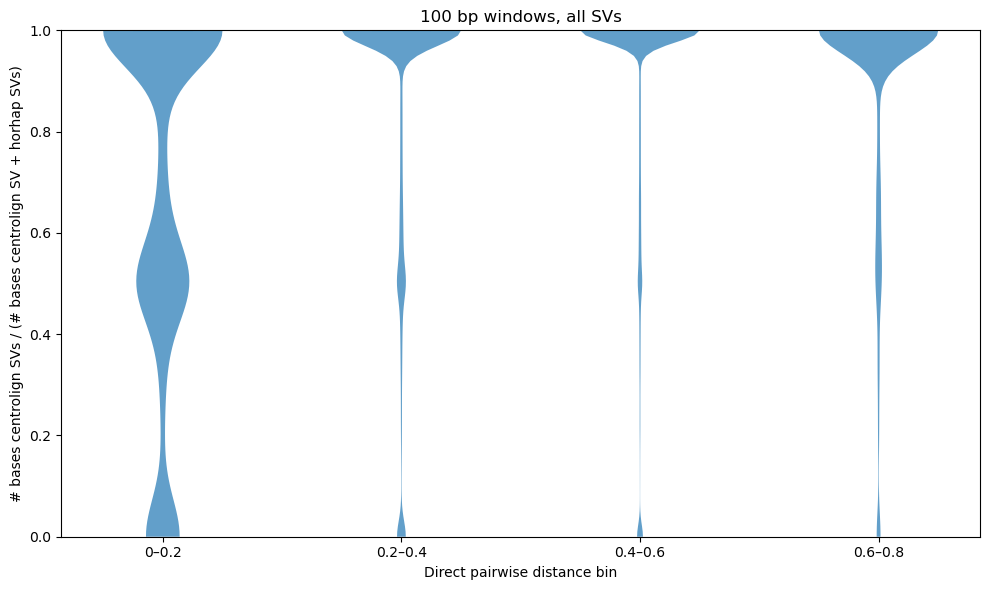

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Only the first 4 bins
bins = [0.0, 0.2, 0.4, 0.6, 0.8]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8"]

df = all_svs_100bp_df_merged.copy()

df["dist_bin"] = pd.cut(
    df["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

df_plot = df.dropna(subset=["dist_bin", "cen_prop"])

data_per_bin = [
    df_plot.loc[df_plot["dist_bin"] == label, "cen_prop"].values
    for label in labels
]
plt.figure(figsize=(10, 6))

vp = plt.violinplot(
    data_per_bin,
    positions=np.arange(len(labels)),
    showmeans=False,
    showmedians=True,
    showextrema=False
)

# Style violins
for body in vp["bodies"]:
    body.set_alpha(0.7)

plt.xticks(np.arange(len(labels)), labels)
plt.xlabel("Direct pairwise distance bin")
plt.ylabel("# bases centrolign SVs / (# bases centrolign SV + horhap SVs)")
plt.title("100 bp windows, all SVs")

plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [38]:
### Calculate the average concordance per sample 

# create an order-independent pair column
all_svs_100bp_df_merged["sample_pair"] = all_svs_100bp_df_merged.apply(
    lambda r: tuple(sorted([r["sample1"], r["sample2"]])),
    axis=1
)

# group by the unordered pair and calculate mean cen_prop
avg_cen_prop_all_svs_100bp = (
    all_svs_100bp_df_merged.groupby("sample_pair", as_index=False)
      .agg(
          avg_cen_prop=("cen_prop", "mean"),
          direct_pairwise_dist=("direct_pairwise_dist", "first")
      )
)
print(avg_cen_prop_all_svs_100bp)


                 sample_pair  avg_cen_prop  direct_pairwise_dist
0     (HG00099.1, HG00126.2)      0.914358              0.534728
1     (HG00099.1, HG00128.1)      0.678380              0.118052
2     (HG00099.1, HG00133.1)      0.559595              0.042255
3     (HG00099.1, HG00140.2)      0.695287              0.121332
4     (HG00099.1, HG00232.2)      0.887120              0.407784
...                      ...           ...                   ...
1480  (NA20905.1, NA21106.1)      0.874201              0.415930
1481  (NA20905.1, NA21106.2)      0.888610              0.373868
1482  (NA21102.2, NA21106.1)      0.890398              0.424940
1483  (NA21102.2, NA21106.2)      0.685495              0.136764
1484  (NA21106.1, NA21106.2)      0.896082              0.396133

[1485 rows x 3 columns]


/private/home/mmastora/miniconda3/envs/ipynb/lib/python3.14/site-packages/seaborn/categorical.py:3399: UserWarning: 5.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/private/home/mmastora/miniconda3/envs/ipynb/lib/python3.14/site-packages/seaborn/categorical.py:3399: UserWarning: 35.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/private/home/mmastora/miniconda3/envs/ipynb/lib/python3.14/site-packages/seaborn/categorical.py:3399: UserWarning: 9.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


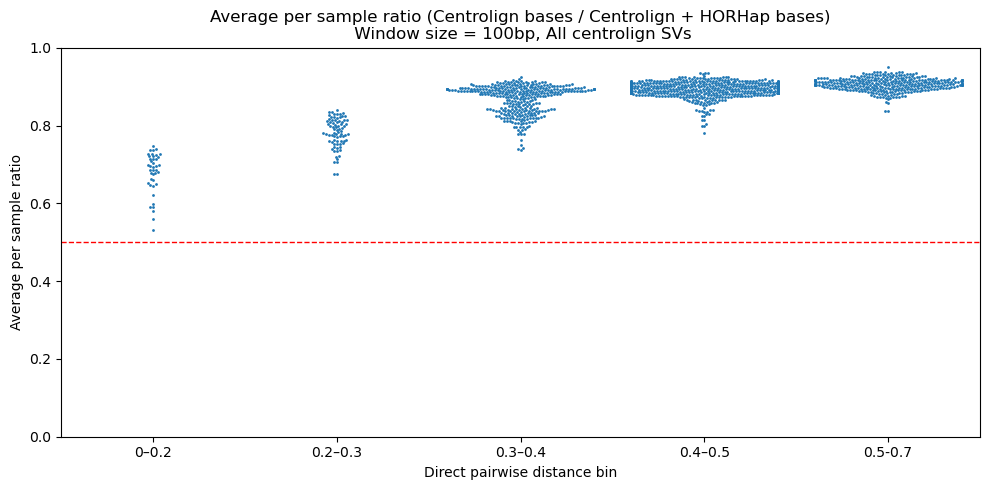

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bins = [0.0, 0.2, 0.3, 0.4, 0.5, 0.7]
labels = ["0–0.2", "0.2–0.3", "0.3–0.4", "0.4–0.5", "0.5-0.7"]

avg_cen_prop_all_svs_100bp["dist_bin"] = pd.cut(
    avg_cen_prop_all_svs_100bp["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

plt.figure(figsize=(10, 5))
sns.swarmplot(
    data=avg_cen_prop_all_svs_100bp,
    x="dist_bin",
    y="avg_cen_prop",
    size=2
)

# horizontal reference line at y = 0.5
plt.axhline(
    y=0.5,
    color="red",
    linestyle="--",
    linewidth=1
)
plt.xlabel("Direct pairwise distance bin")
plt.ylim(0,1)
plt.ylabel("Average per sample ratio")
plt.title("Average per sample ratio (Centrolign bases / Centrolign + HORHap bases)\n Window size = 100bp, All centrolign SVs")
plt.tight_layout()
plt.show()


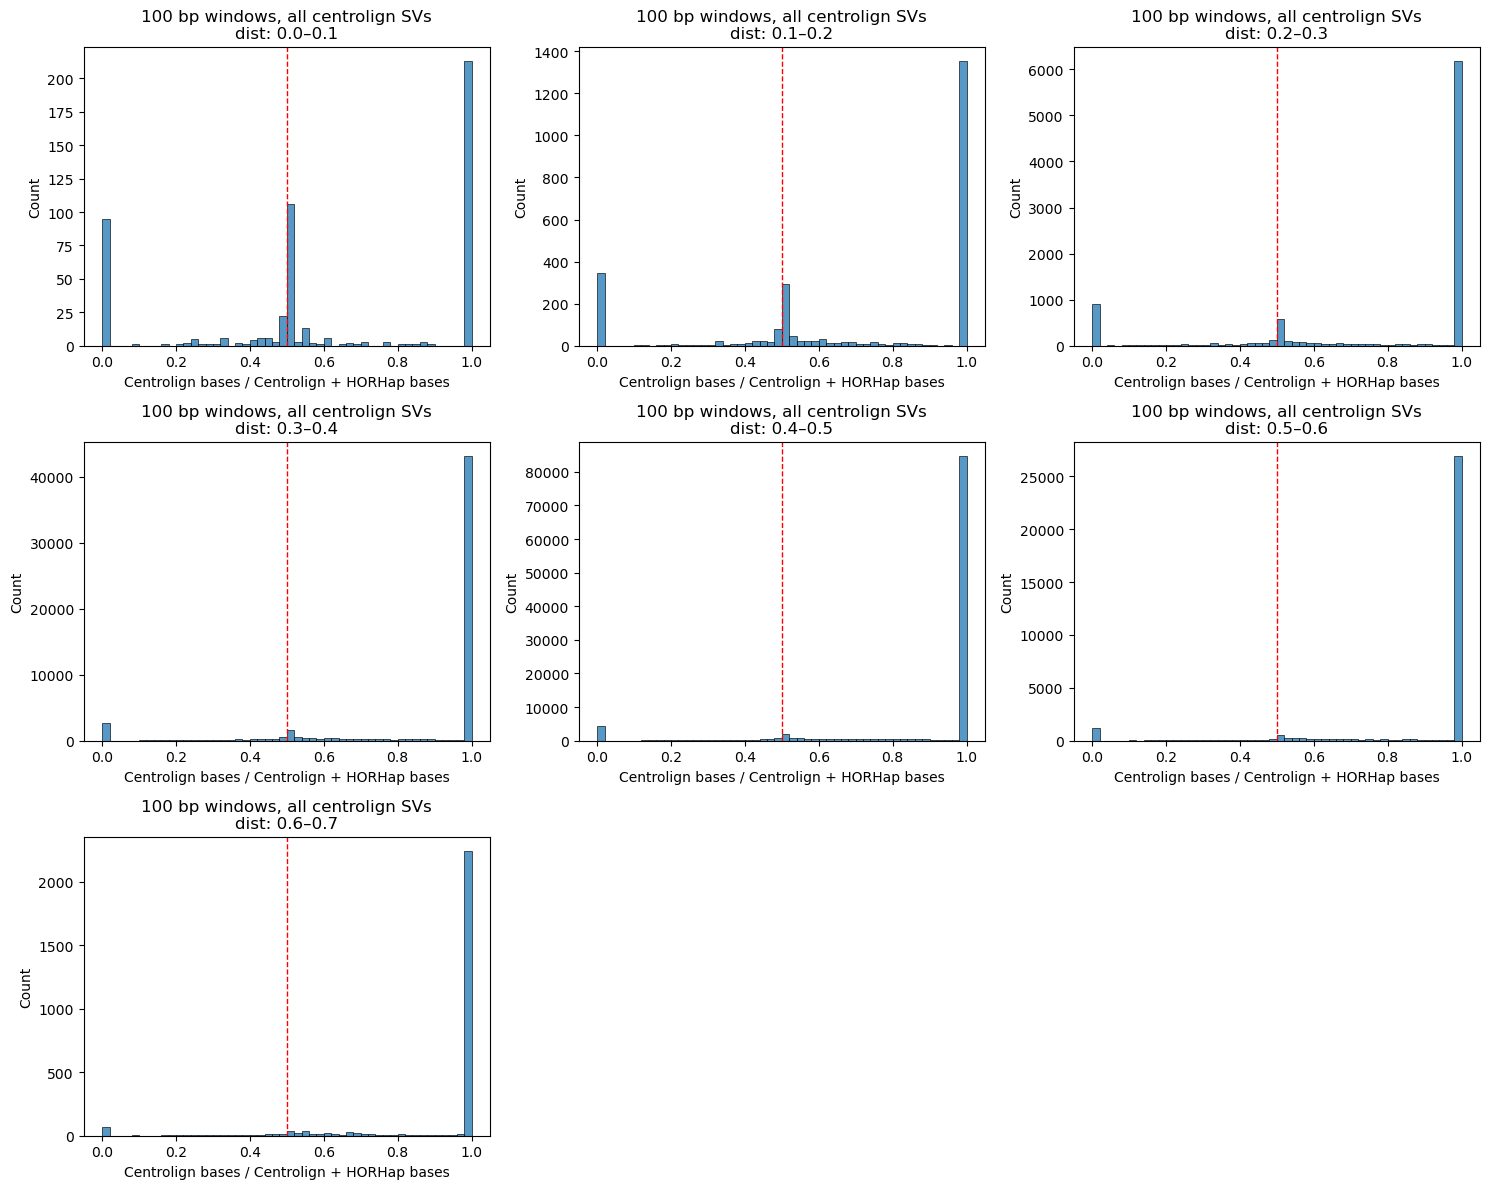

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define bins
bins = [
    (0.0, 0.1),
    (0.1, 0.2),
    (0.2, 0.3),
    (0.3, 0.4),
    (0.4, 0.5),
    (0.5, 0.6),
    (0.6, 0.7),
]

# Create subplots (adjust layout as needed)
fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(15, 12)
)

axes = axes.flatten()

for ax, (low, high) in zip(axes, bins):
    df_bin = all_svs_100bp_df_merged[
        (all_svs_100bp_df_merged["direct_pairwise_dist"] >= low) &
        (all_svs_100bp_df_merged["direct_pairwise_dist"] < high)
    ]

    sns.histplot(
        data=df_bin,
        x="cen_prop",
        bins=50,
        ax=ax
    )

    ax.axvline(
        0.5,
        color="red",
        linestyle="--",
        linewidth=1
    )

    ax.set_title(f"100 bp windows, all centrolign SVs\ndist: {low:.1f}–{high:.1f}")
    ax.set_xlabel("Centrolign bases / Centrolign + HORHap bases")
    ax.set_ylabel("Count")

# Remove unused panels (since 3x3 = 9 but we only need 7)
for ax in axes[len(bins):]:
    ax.axis("off")

plt.tight_layout()
plt.show()



### 1000 bp windows, all SVs 

In [43]:
folder = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/chr12/cenhap4"
suffix = "all_SVs.1000bp.bed"
all_svs_1000bp_df = read_beds(folder,suffix)
all_svs_1000bp_df["chr"]="chr12"
print(all_svs_1000bp_df.head())

      sample  window_start  window_end  centrolign_counts  horhap_counts  \
0  HG00126.2      34708991    34715618               3737              0   
1  HG00126.2      34719721    34727491               5770              0   
2  HG00126.2      34735738    34745966               8228              0   
3  HG00126.2      34747038    34757342               6479              0   
4  HG00126.2      34758052    34760538                486              0   

     sample2  ratio    chr  
0  HG00329.2    0.0  chr12  
1  HG00329.2    0.0  chr12  
2  HG00329.2    0.0  chr12  
3  HG00329.2    0.0  chr12  
4  HG00329.2    0.0  chr12  


In [45]:
## merge with all pairs distances 

all_svs_1000bp_df = all_svs_1000bp_df.rename(columns={"sample": "sample1"})

all_svs_1000bp_df_merged = (
    all_svs_1000bp_df
    .merge(all_pairs_dist_df, on=["sample1", "sample2","chr"], how="left")
)

all_svs_1000bp_df_merged.head()

denom = all_svs_1000bp_df_merged["centrolign_counts"] + all_svs_1000bp_df_merged["horhap_counts"]

all_svs_1000bp_df_merged["cen_prop"] = np.where(
    denom > 0,
    all_svs_1000bp_df_merged["centrolign_counts"] / denom,
    0
)
all_svs_1000bp_df_merged.head()

,sample1,window_start,window_end,centrolign_counts,horhap_counts,sample2,ratio,chr,direct_pairwise_dist,cen_prop
0,HG00126.2,34708991,34715618,3737,0,HG00329.2,0.0,chr12,0.562033,1.0
1,HG00126.2,34719721,34727491,5770,0,HG00329.2,0.0,chr12,0.562033,1.0
2,HG00126.2,34735738,34745966,8228,0,HG00329.2,0.0,chr12,0.562033,1.0
3,HG00126.2,34747038,34757342,6479,0,HG00329.2,0.0,chr12,0.562033,1.0
4,HG00126.2,34758052,34760538,486,0,HG00329.2,0.0,chr12,0.562033,1.0


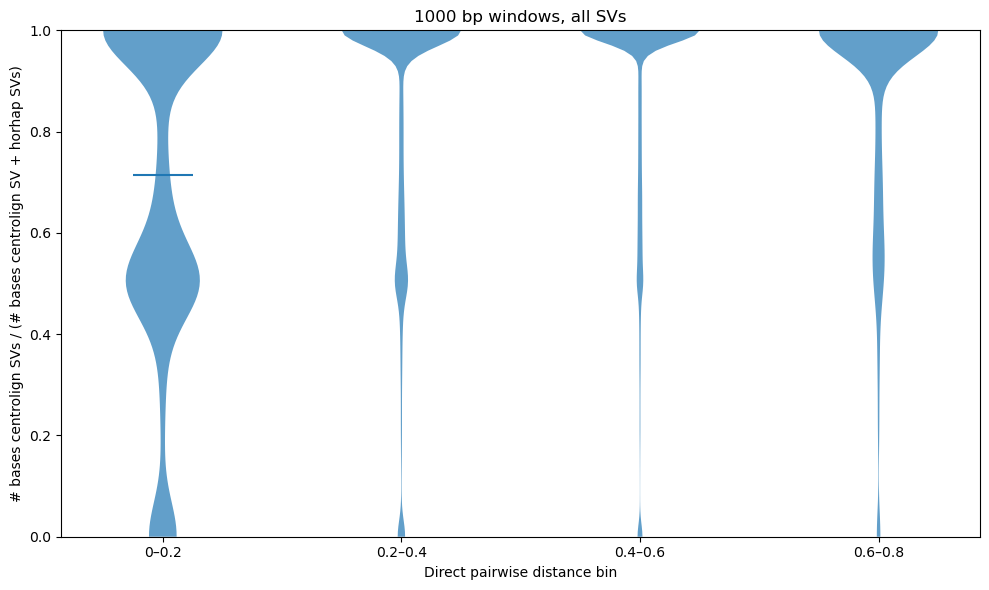

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Only the first 4 bins
bins = [0.0, 0.2, 0.4, 0.6, 0.8]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8"]

df = all_svs_1000bp_df_merged.copy()

df["dist_bin"] = pd.cut(
    df["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

df_plot = df.dropna(subset=["dist_bin", "cen_prop"])

data_per_bin = [
    df_plot.loc[df_plot["dist_bin"] == label, "cen_prop"].values
    for label in labels
]
plt.figure(figsize=(10, 6))

vp = plt.violinplot(
    data_per_bin,
    positions=np.arange(len(labels)),
    showmeans=False,
    showmedians=True,
    showextrema=False
)

# Style violins
for body in vp["bodies"]:
    body.set_alpha(0.7)

plt.xticks(np.arange(len(labels)), labels)
plt.xlabel("Direct pairwise distance bin")
plt.ylabel("# bases centrolign SVs / (# bases centrolign SV + horhap SVs)")
plt.title("1000 bp windows, all SVs")

plt.ylim(0, 1)
plt.tight_layout()
plt.show()

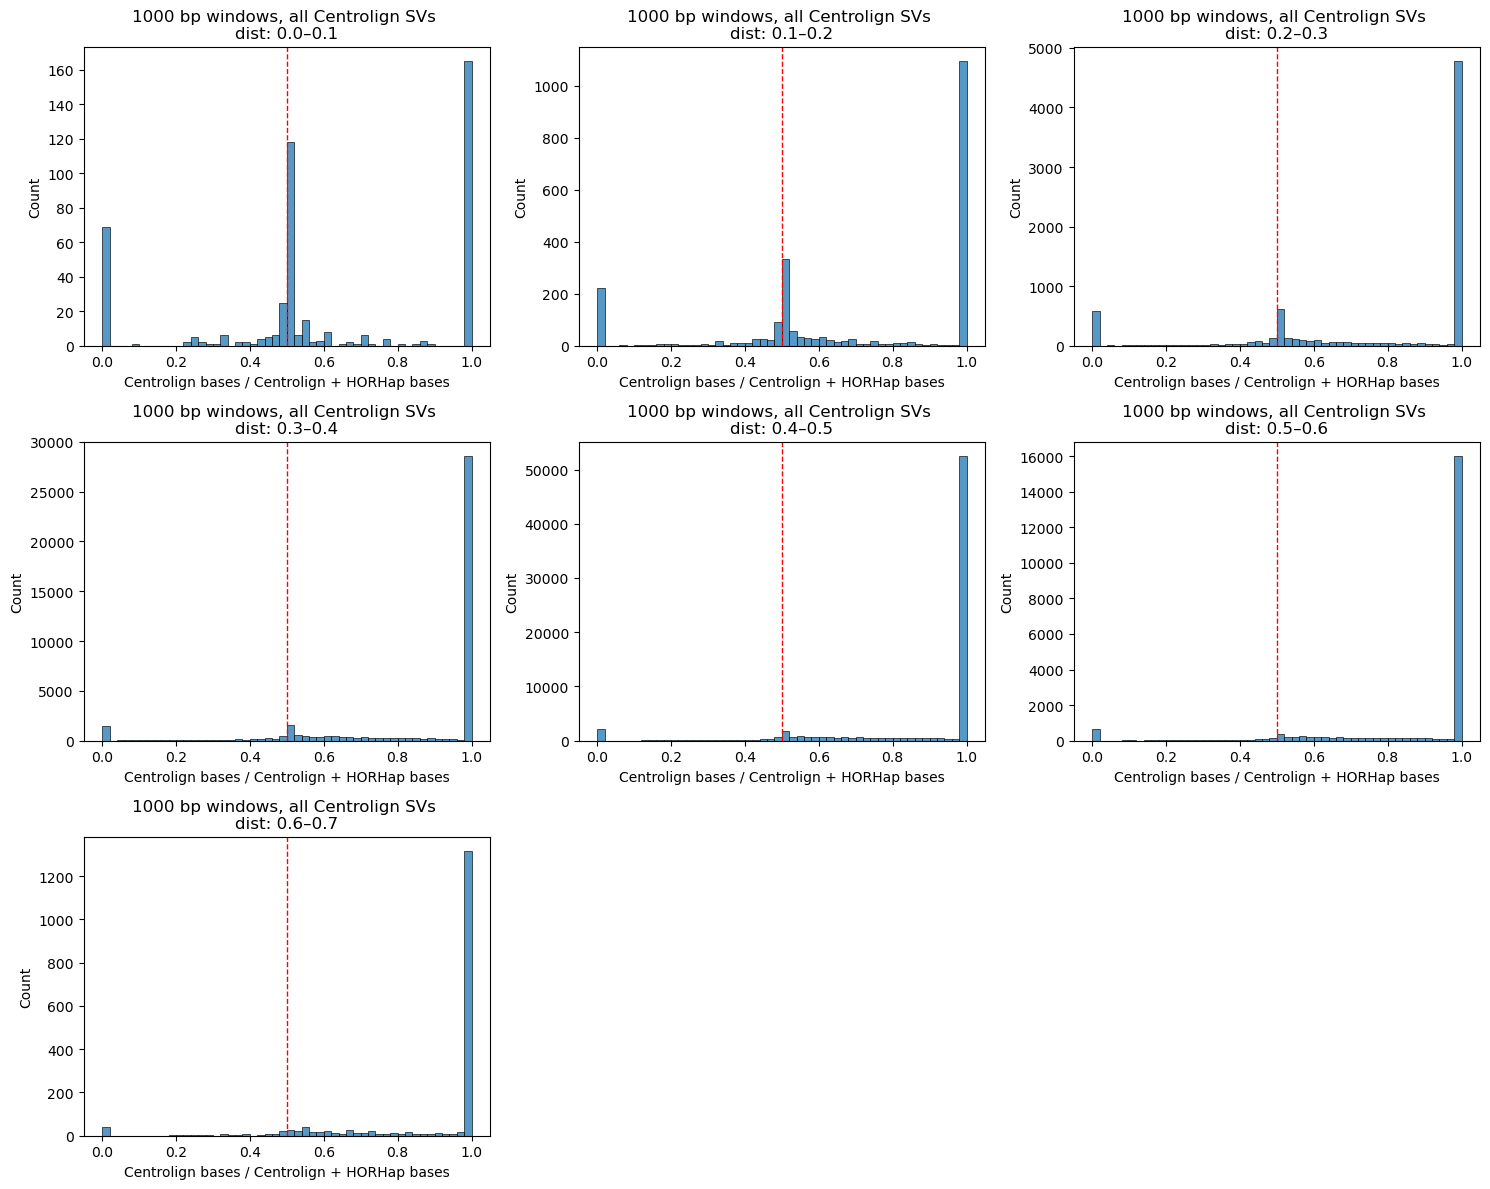

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define bins
bins = [
    (0.0, 0.1),
    (0.1, 0.2),
    (0.2, 0.3),
    (0.3, 0.4),
    (0.4, 0.5),
    (0.5, 0.6),
    (0.6, 0.7),
]

# Create subplots (adjust layout as needed)
fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(15, 12)
)

axes = axes.flatten()

for ax, (low, high) in zip(axes, bins):
    df_bin = all_svs_1000bp_df_merged[
        (all_svs_1000bp_df_merged["direct_pairwise_dist"] >= low) &
        (all_svs_1000bp_df_merged["direct_pairwise_dist"] < high)
    ]

    sns.histplot(
        data=df_bin,
        x="cen_prop",
        bins=50,
        ax=ax
    )

    ax.axvline(
        0.5,
        color="red",
        linestyle="--",
        linewidth=1
    )

    ax.set_title(f"1000 bp windows, all Centrolign SVs \ndist: {low:.1f}–{high:.1f}")
    ax.set_xlabel("Centrolign bases / Centrolign + HORHap bases")
    ax.set_ylabel("Count")

# Remove unused panels (since 3x3 = 9 but we only need 7)
for ax in axes[len(bins):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [47]:
### Calculate the average concordance per sample 

# create an order-independent pair column
all_svs_1000bp_df_merged["sample_pair"] = all_svs_1000bp_df_merged.apply(
    lambda r: tuple(sorted([r["sample1"], r["sample2"]])),
    axis=1
)

# group by the unordered pair and calculate mean cen_prop
avg_cen_prop_all_svs_1000bp = (
    all_svs_1000bp_df_merged.groupby("sample_pair", as_index=False)
      .agg(
          avg_cen_prop=("cen_prop", "mean"),
          direct_pairwise_dist=("direct_pairwise_dist", "first")
      )
)
print(avg_cen_prop_all_svs_1000bp)

                 sample_pair  avg_cen_prop  direct_pairwise_dist
0     (HG00099.1, HG00126.2)      0.886465              0.534728
1     (HG00099.1, HG00128.1)      0.674608              0.118052
2     (HG00099.1, HG00133.1)      0.547987              0.042255
3     (HG00099.1, HG00140.2)      0.694322              0.121332
4     (HG00099.1, HG00232.2)      0.876734              0.407784
...                      ...           ...                   ...
1480  (NA20905.1, NA21106.1)      0.874413              0.415930
1481  (NA20905.1, NA21106.2)      0.885123              0.373868
1482  (NA21102.2, NA21106.1)      0.876503              0.424940
1483  (NA21102.2, NA21106.2)      0.686086              0.136764
1484  (NA21106.1, NA21106.2)      0.878838              0.396133

[1485 rows x 3 columns]


/private/home/mmastora/miniconda3/envs/ipynb/lib/python3.14/site-packages/seaborn/categorical.py:3399: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/private/home/mmastora/miniconda3/envs/ipynb/lib/python3.14/site-packages/seaborn/categorical.py:3399: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


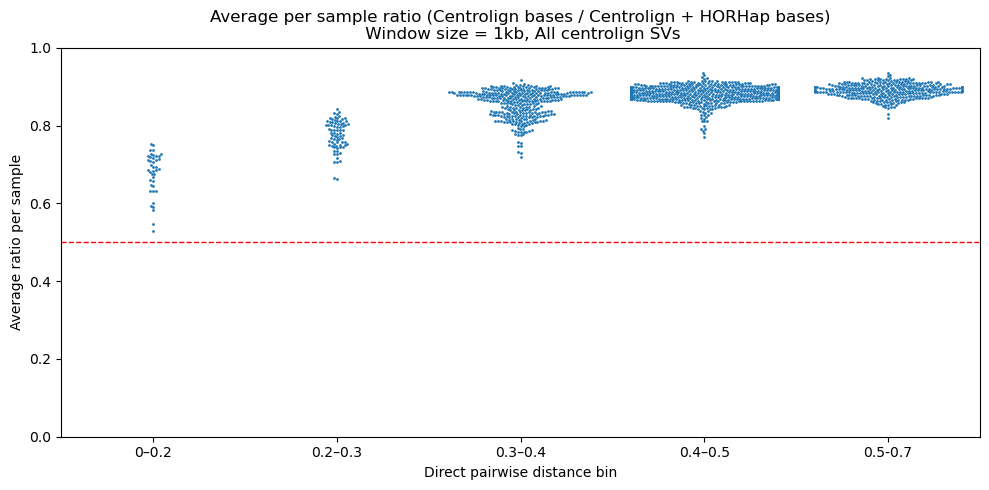

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bins = [0.0, 0.2, 0.3, 0.4, 0.5, 0.7]
labels = ["0–0.2", "0.2–0.3", "0.3–0.4", "0.4–0.5", "0.5-0.7"]

avg_cen_prop_all_svs_1000bp["dist_bin"] = pd.cut(
    avg_cen_prop_all_svs_1000bp["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

plt.figure(figsize=(10, 5))
sns.swarmplot(
    data=avg_cen_prop_all_svs_1000bp,
    x="dist_bin",
    y="avg_cen_prop",
    size=2
)

# horizontal reference line at y = 0.5
plt.axhline(
    y=0.5,
    color="red",
    linestyle="--",
    linewidth=1
)
plt.xlabel("Direct pairwise distance bin")
plt.ylim(0,1)
plt.ylabel("Average ratio per sample")
plt.title("Average per sample ratio (Centrolign bases / Centrolign + HORHap bases)\n Window size = 1kb, All centrolign SVs")
plt.tight_layout()
plt.show()

### 1000 bp windows, just triangles

In [8]:
folder = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/chr12/cenhap4"
suffix = "triangles.1000bp.bed"
triangles_1000bp_df = read_beds(folder,suffix)
triangles_1000bp_df["chr"]="chr12"
print(triangles_1000bp_df.head())

      sample  window_start  window_end  centrolign_counts  horhap_counts  \
0  HG00232.2      34760397    34778865              14263          10881   
1  HG00232.2      34784758    34788116               1358              0   
2  HG00232.2      34804224    34810636               4412              0   
3  HG00232.2      34815692    34819051               1359              0   
4  HG00232.2      34845760    34848436                676              0   

     sample2     ratio    chr  
0  HG01106.1  1.310817  chr12  
1  HG01106.1  0.000000  chr12  
2  HG01106.1  0.000000  chr12  
3  HG01106.1  0.000000  chr12  
4  HG01106.1  0.000000  chr12  


In [9]:
## merge with all pairs distances 

triangles_1000bp_df = triangles_1000bp_df.rename(columns={"sample": "sample1"})

triangles_1000bp_df_merged = (
    triangles_1000bp_df
    .merge(all_pairs_dist_df, on=["sample1", "sample2","chr"], how="left")
)

triangles_1000bp_df_merged.head()

denom = triangles_1000bp_df_merged["centrolign_counts"] + triangles_1000bp_df_merged["horhap_counts"]

triangles_1000bp_df_merged["cen_prop"] = np.where(
    denom > 0,
    triangles_1000bp_df_merged["centrolign_counts"] / denom,
    0
)
triangles_1000bp_df_merged.head()

,sample1,window_start,window_end,centrolign_counts,horhap_counts,sample2,ratio,chr,direct_pairwise_dist,cen_prop
0,HG00232.2,34760397,34778865,14263,10881,HG01106.1,1.310817,chr12,0.61767,0.567253
1,HG00232.2,34784758,34788116,1358,0,HG01106.1,0.000000,chr12,0.61767,1.000000
2,HG00232.2,34804224,34810636,4412,0,HG01106.1,0.000000,chr12,0.61767,1.000000
3,HG00232.2,34815692,34819051,1359,0,HG01106.1,0.000000,chr12,0.61767,1.000000
4,HG00232.2,34845760,34848436,676,0,HG01106.1,0.000000,chr12,0.61767,1.000000


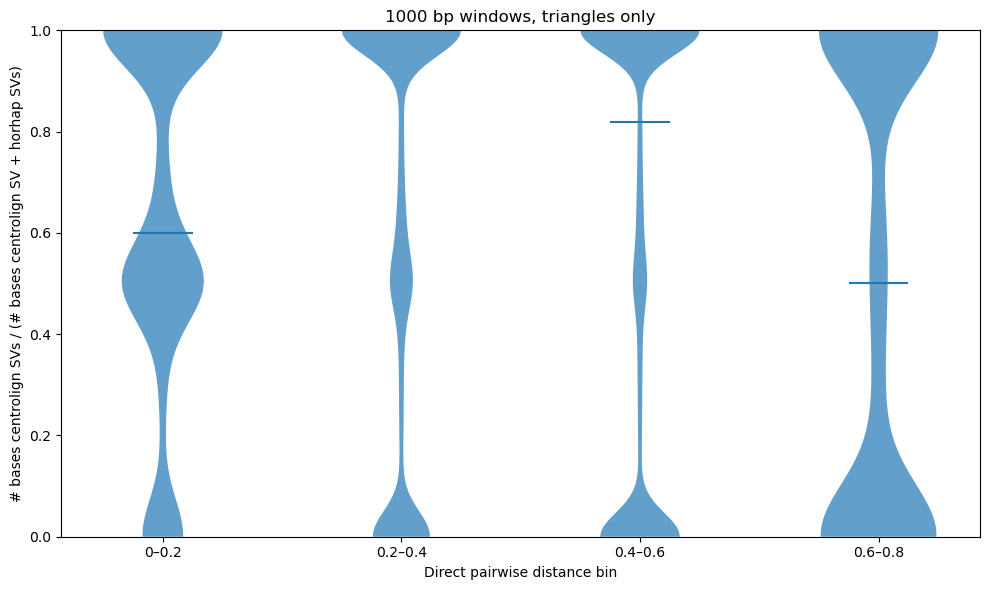

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Only the first 4 bins
bins = [0.0, 0.2, 0.4, 0.6, 0.8]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8"]

df = triangles_1000bp_df_merged.copy()

df["dist_bin"] = pd.cut(
    df["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

df_plot = df.dropna(subset=["dist_bin", "cen_prop"])

data_per_bin = [
    df_plot.loc[df_plot["dist_bin"] == label, "cen_prop"].values
    for label in labels
]
plt.figure(figsize=(10, 6))

vp = plt.violinplot(
    data_per_bin,
    positions=np.arange(len(labels)),
    showmeans=False,
    showmedians=True,
    showextrema=False
)

# Style violins
for body in vp["bodies"]:
    body.set_alpha(0.7)

plt.xticks(np.arange(len(labels)), labels)
plt.xlabel("Direct pairwise distance bin")
plt.ylabel("# bases centrolign SVs / (# bases centrolign SV + horhap SVs)")
plt.title("1000 bp windows, triangles only")

plt.ylim(0, 1)
plt.tight_layout()
plt.show()

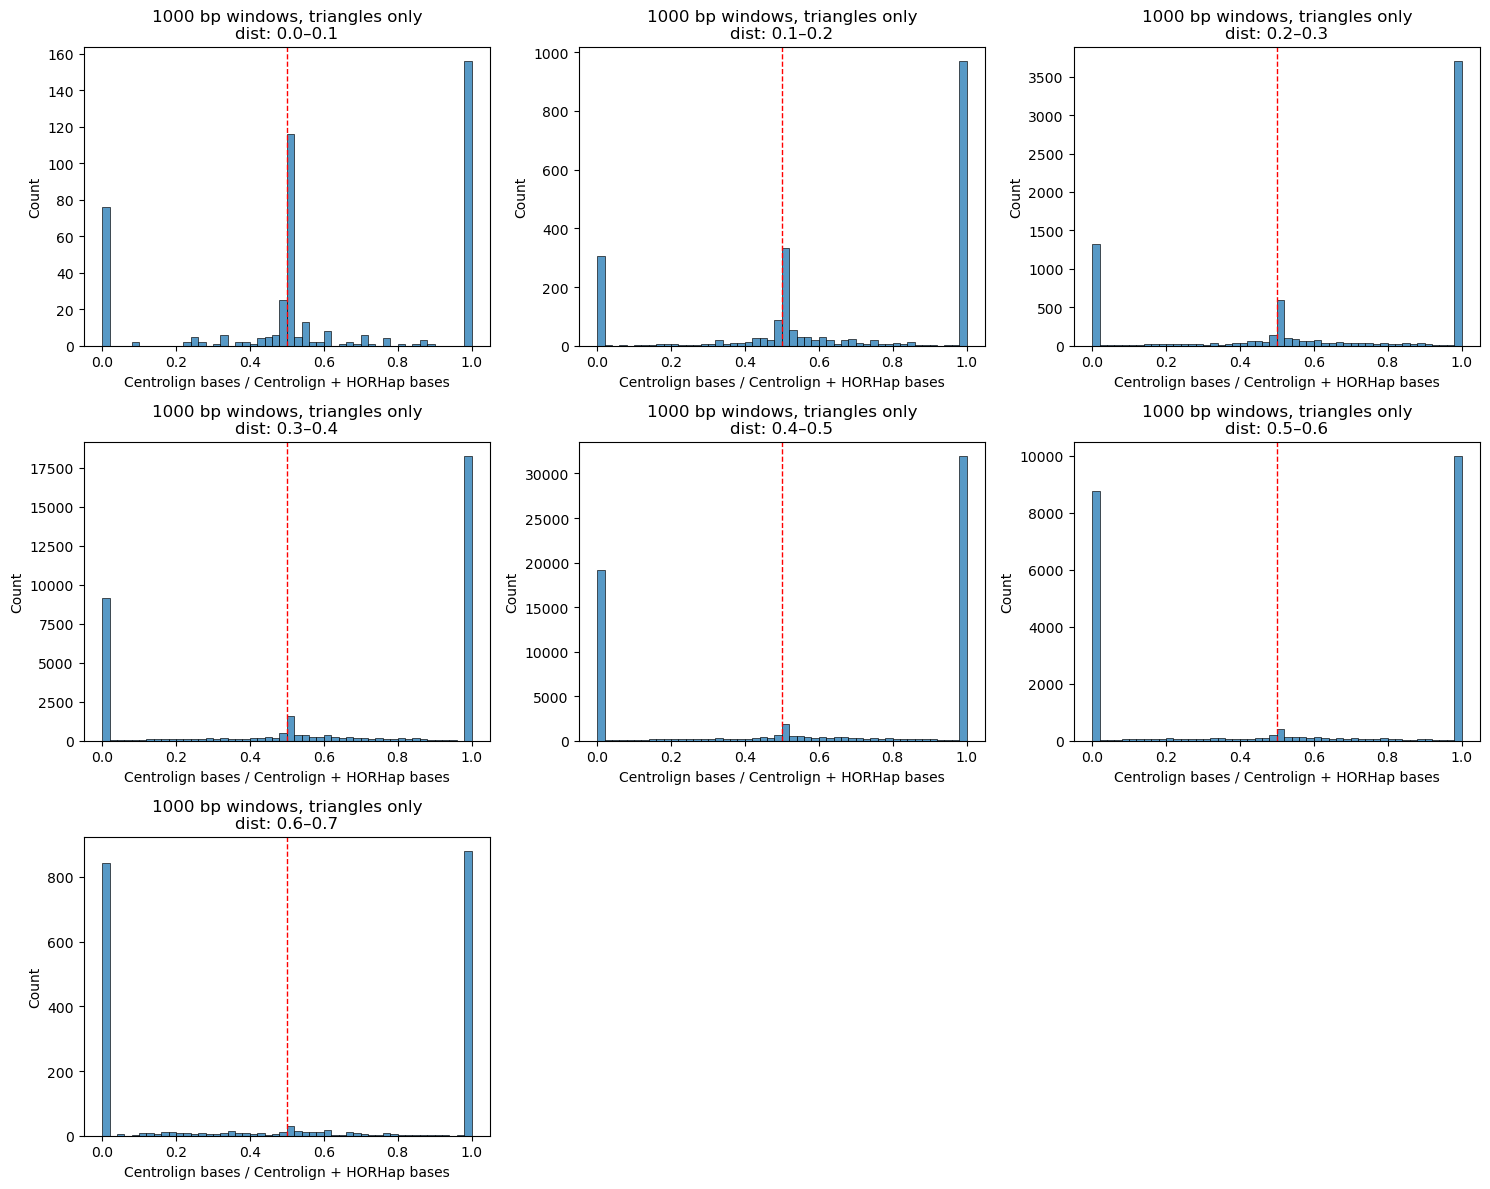

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define bins
bins = [
    (0.0, 0.1),
    (0.1, 0.2),
    (0.2, 0.3),
    (0.3, 0.4),
    (0.4, 0.5),
    (0.5, 0.6),
    (0.6, 0.7),
]

# Create subplots (adjust layout as needed)
fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(15, 12)
)

axes = axes.flatten()

for ax, (low, high) in zip(axes, bins):
    df_bin = triangles_1000bp_df_merged[
        (triangles_1000bp_df_merged["direct_pairwise_dist"] >= low) &
        (triangles_1000bp_df_merged["direct_pairwise_dist"] < high)
    ]

    sns.histplot(
        data=df_bin,
        x="cen_prop",
        bins=50,
        ax=ax
    )

    ax.axvline(
        0.5,
        color="red",
        linestyle="--",
        linewidth=1
    )

    ax.set_title(f"1000 bp windows, triangles only\ndist: {low:.1f}–{high:.1f}")
    ax.set_xlabel("Centrolign bases / Centrolign + HORHap bases")
    ax.set_ylabel("Count")

# Remove unused panels (since 3x3 = 9 but we only need 7)
for ax in axes[len(bins):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [10]:
### Calculate the average concordance per sample 

# create an order-independent pair column
triangles_1000bp_df_merged["sample_pair"] = triangles_1000bp_df_merged.apply(
    lambda r: tuple(sorted([r["sample1"], r["sample2"]])),
    axis=1
)

# group by the unordered pair and calculate mean cen_prop
avg_cen_prop_triangles_1000bp = (
    triangles_1000bp_df_merged.groupby("sample_pair", as_index=False)
      .agg(
          avg_cen_prop=("cen_prop", "mean"),
          direct_pairwise_dist=("direct_pairwise_dist", "first")
      )
)
print(avg_cen_prop_triangles_1000bp)

                 sample_pair  avg_cen_prop  direct_pairwise_dist
0     (HG00099.1, HG00126.2)      0.414615              0.534728
1     (HG00099.1, HG00128.1)      0.648691              0.118052
2     (HG00099.1, HG00133.1)      0.535430              0.042255
3     (HG00099.1, HG00140.2)      0.649935              0.121332
4     (HG00099.1, HG00232.2)      0.601518              0.407784
...                      ...           ...                   ...
1480  (NA20905.1, NA21106.1)      0.671370              0.415930
1481  (NA20905.1, NA21106.2)      0.610960              0.373868
1482  (NA21102.2, NA21106.1)      0.668211              0.424940
1483  (NA21102.2, NA21106.2)      0.680939              0.136764
1484  (NA21106.1, NA21106.2)      0.670149              0.396133

[1485 rows x 3 columns]


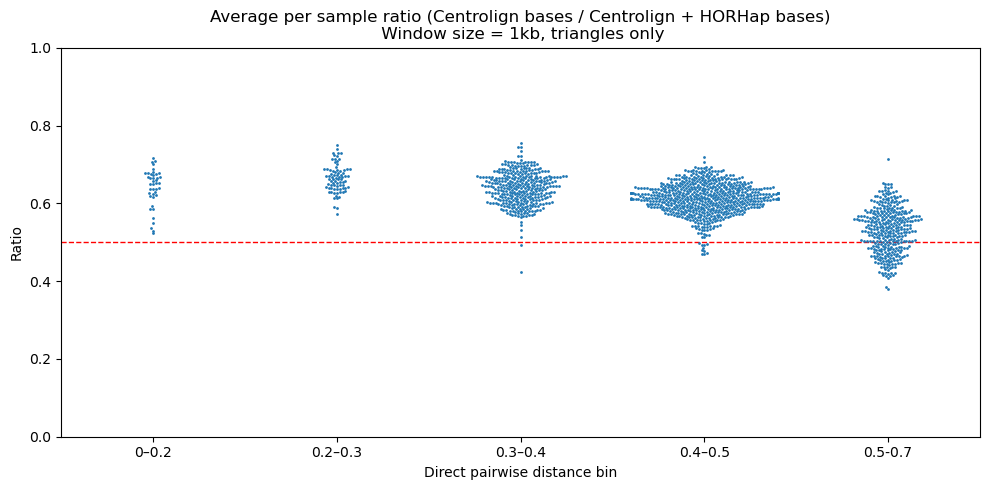

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bins = [0.0, 0.2, 0.3, 0.4, 0.5, 0.7]
labels = ["0–0.2", "0.2–0.3", "0.3–0.4", "0.4–0.5", "0.5-0.7"]

avg_cen_prop_triangles_1000bp["dist_bin"] = pd.cut(
    avg_cen_prop_triangles_1000bp["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

plt.figure(figsize=(10, 5))
sns.swarmplot(
    data=avg_cen_prop_triangles_1000bp,
    x="dist_bin",
    y="avg_cen_prop",
    size=2
)

# horizontal reference line at y = 0.5
plt.axhline(
    y=0.5,
    color="red",
    linestyle="--",
    linewidth=1
)
plt.xlabel("Direct pairwise distance bin")
plt.ylim(0,1)
plt.ylabel("Ratio")
plt.title("Average per sample ratio (Centrolign bases / Centrolign + HORHap bases)\n Window size = 1kb, triangles only")
plt.tight_layout()
plt.show()

In [60]:
# Get samples with highest cen_prop values
top3 = (
    avg_cen_prop_triangles_1000bp[avg_cen_prop_triangles_1000bp["direct_pairwise_dist"] < 0.2]
    .sort_values("avg_cen_prop", ascending=False)
    .head(3)
)

print(top3)



                 sample_pair  avg_cen_prop  direct_pairwise_dist dist_bin
1248  (HG02280.2, NA20809.2)      0.716225              0.144713    0–0.2
436   (HG00290.2, HG03710.1)      0.708858              0.188366    0–0.2
642   (HG00735.2, HG02280.2)      0.706917              0.149905    0–0.2


In [11]:
top3 = (
    avg_cen_prop_triangles_1000bp[
        (avg_cen_prop_triangles_1000bp["direct_pairwise_dist"] < 0.2) &
        (avg_cen_prop_triangles_1000bp["avg_cen_prop"] >= 0.5) &
        (avg_cen_prop_triangles_1000bp["avg_cen_prop"] <= 0.55)
    ]
    .sort_values("avg_cen_prop", ascending=False)
    .head(10)
)

print(top3)


                 sample_pair  avg_cen_prop  direct_pairwise_dist
659   (HG00735.2, NA20809.2)      0.548272              0.040491
2     (HG00099.1, HG00133.1)      0.535430              0.042255
1301  (HG02698.1, HG03784.2)      0.529980              0.168366
25    (HG00099.1, HG01891.1)      0.522803              0.037073
